## Goal: In analysis, seeing some weird signals in surface wind. Why? 
<b>Author:</b> Meg Fowler <br>
<b>Date:</b> 16 Sept 2020
<br><br>
As a step towards understanding why we're seeing some enclosed regions over US and Africa, say, with nearly zero wind speeds in JJA, let's look at a few years of daily wind speed. 

In [1]:
# Load libraries

# Plotting utils 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import matplotlib.ticker as ticker 
import matplotlib.patches as patches
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.util

# Analysis
import Ngl
import numpy
import Nio
import os
import numpy as np 
import xarray as xr
import datetime
from   datetime import date, timedelta
import pandas as pd 
import pickle


## Read in file 

In [3]:
dataDir  = '/glade/work/mdfowler/data/CLUBB_sim/'
fileName = dataDir+'f.e20.FHIST.f09_f09.cesm2_1.001.cam.h1.1970-79_dailyU.nc'

ds = xr.open_dataset(fileName, decode_times=True)
ds['time'] = ds.indexes['time'].to_datetimeindex()


/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  """


In [4]:
# To be able to easily access years, months, days - use Pandas 
dates = pd.DatetimeIndex(ds['time'].values) 


### Flip levels

In [5]:
# Oriented such that the sfc level is actually the last level in array 
#   Much easier to work with if you flip the levels 

U          = ds.U              # Zonal wind (m/s)
U          = np.flip(U, axis=1)
lev_middle = np.flip(ds.lev.values)


In [ ]:
(U.values[10,0,10,10])

In [ ]:
ds.U.values[10,-1,10,10]

## Isolate JJA only 

In [32]:
# Get indices of JJA
iKeep  = np.where((dates.month>=6) & (dates.month<=8))[0]
ds_sel = ds.isel(time=iKeep)
U_sel  = U.isel(time=iKeep)
dates  = dates[iKeep]

lat = U_sel.lat.values
lon = U_sel.lon.values


**Just to make sure - the flip worked okay?**

In [14]:
(U_sel.values[120,0,30,50])

6.5604744

In [15]:
ds_sel.U.values[120,-1,30,50]

6.5604744

## Histogram of surface U values in key regions 

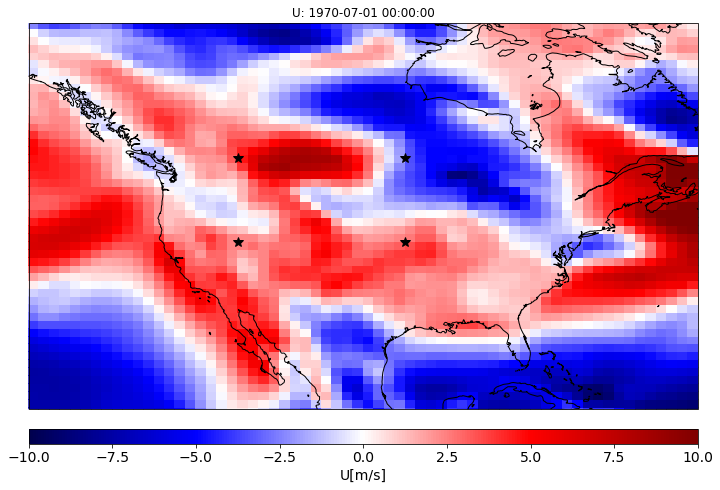

In [48]:
sfcU = U_sel[:,0,:,:]

# Set up figure 
fig, ax1 = plt.subplots(1,1, figsize=(12, 8), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})
# Put axs handles in array, axs 

# Make cyclic 
iDay = 30 
sfcU_day_cyclic, lon_cyclic    = cartopy.util.add_cyclic_point(sfcU[iDay,:,:], lon)

# Midwest US 
ax1.set_extent([220,300,20,60])
contour_plot = ax1.pcolormesh(lon_cyclic,lat,sfcU_day_cyclic,
                                 vmin = -10,
                                 vmax = 10,
                                 cmap = 'seismic')
ax1.coastlines()        # Add continent lines 

# Add colorbar 
ax_position = ax1.get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.06, ax_position.width, 0.025])
cbar        = plt.colorbar(contour_plot, orientation='horizontal', cax=cbar_ax)
cbar.set_label('U[m/s]',fontsize=14)
cbar.ax.tick_params(labelsize=14)

# Add some points
ax1.plot(245,50,'k*',markersize=10,transform=ccrs.PlateCarree())
ax1.plot(245,40,'k*',markersize=10,transform=ccrs.PlateCarree())
ax1.plot(265,50,'k*',markersize=10,transform=ccrs.PlateCarree())
ax1.plot(265,40,'k*',markersize=10,transform=ccrs.PlateCarree())

# Set title
ax1.set_title('U: '+str(dates[iDay]))

plt.show()


In [55]:
# Set lat and lon boundaries: 
ilat = np.where((lat>=40.) & (lat<=50.))[0]
ilon = np.where((lon>=245.) & (lon<=265.))[0]

U_selUS = U_sel.isel(lat=ilat, lon=ilon)
U_sfcUS = U_selUS.values[:,0,:,:]

lat_US = lat[ilat]
lon_US = lon[ilon]


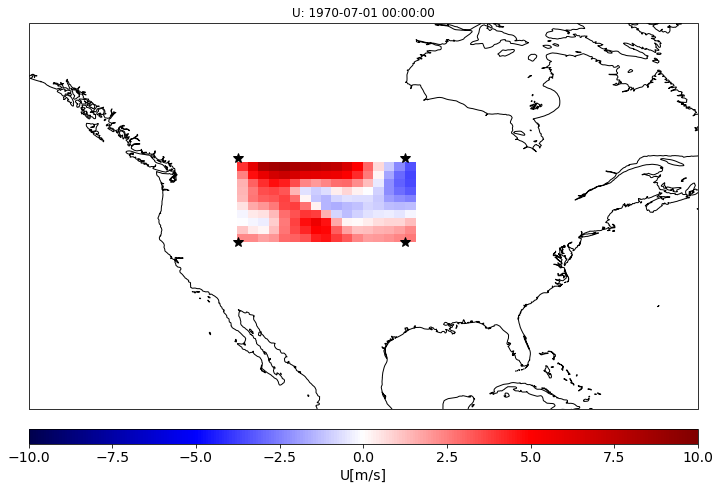

In [56]:
# Set up figure 
fig, ax1 = plt.subplots(1,1, figsize=(12, 8), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})
# Put axs handles in array, axs 

# Make cyclic 
iDay = 30 
sfcU_day_cyclic, lon_cyclic    = cartopy.util.add_cyclic_point(U_sfcUS[iDay,:,:], lon_US)

# Midwest US 
ax1.set_extent([220,300,20,60])
contour_plot = ax1.pcolormesh(lon_cyclic,lat_US,sfcU_day_cyclic,
                                 vmin = -10,
                                 vmax = 10,
                                 cmap = 'seismic')
ax1.coastlines()        # Add continent lines 

# Add colorbar 
ax_position = ax1.get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.06, ax_position.width, 0.025])
cbar        = plt.colorbar(contour_plot, orientation='horizontal', cax=cbar_ax)
cbar.set_label('U[m/s]',fontsize=14)
cbar.ax.tick_params(labelsize=14)

# Add some points
ax1.plot(245,50,'k*',markersize=10,transform=ccrs.PlateCarree())
ax1.plot(245,40,'k*',markersize=10,transform=ccrs.PlateCarree())
ax1.plot(265,50,'k*',markersize=10,transform=ccrs.PlateCarree())
ax1.plot(265,40,'k*',markersize=10,transform=ccrs.PlateCarree())

# Set title
ax1.set_title('U: '+str(dates[iDay]))

plt.show()


In [70]:
# Now make a histogram for one month in this region
yrSel  = 1970 
monSel = 8

iChoice = np.where((dates.month==monSel) & (dates.year==yrSel))[0]

U_choice    = U_selUS.isel(time=iChoice)
Usfc_choice = U_choice.values[:,0,:,:]


Mean U during this month:  -0.35172543


<function matplotlib.pyplot.show(*args, **kw)>

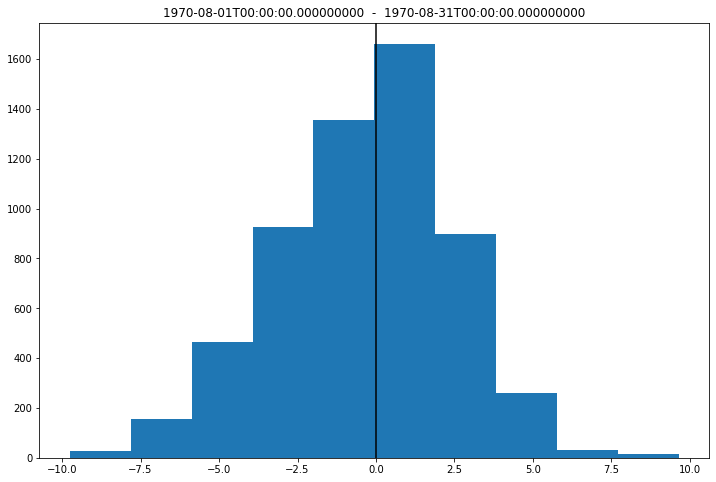

In [73]:
# Flatten U 
Uflat =  Usfc_choice.reshape(len(lat_US)*len(lon_US)*len(U_choice.time))

fig, ax1 = plt.subplots(1,1, figsize=(12, 8))
ax1.hist(Uflat)
ax1.axvline(0, color='k')
ax1.set_title( str(U_choice.time.values[0])+'  -  '+str(U_choice.time.values[-1]) )

print('Mean U during this month: ', np.nanmean(Usfc_choice))

plt.show

### Look at North Africa as well 

In [ ]:
sfcU = U_sel.values[:,0,:,:]

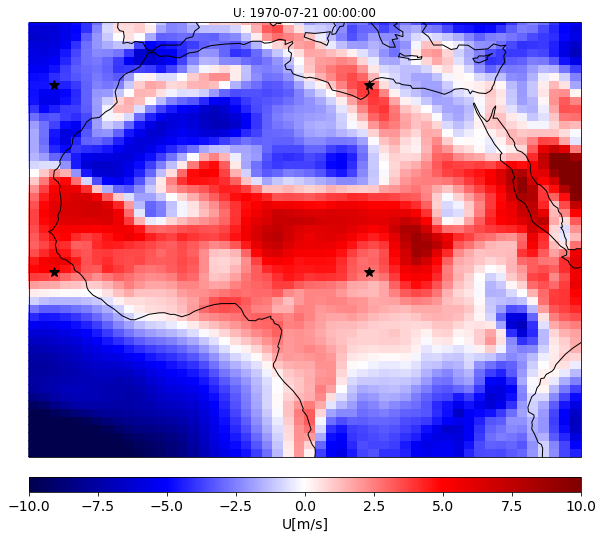

In [84]:
# Set up figure 
fig, ax1 = plt.subplots(1,1, figsize=(12, 8), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})
# Put axs handles in array, axs 

# Make cyclic 
iDay = 50 
sfcU_day_cyclic, lon_cyclic    = cartopy.util.add_cyclic_point(sfcU[iDay,:,:], lon)

# Midwest US 
ax1.set_extent([340,45,-10,35])
contour_plot = ax1.pcolormesh(lon_cyclic,lat,sfcU_day_cyclic,
                                 vmin = -10,
                                 vmax = 10,
                                 cmap = 'seismic')
ax1.coastlines()        # Add continent lines 

# Add colorbar 
ax_position = ax1.get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.06, ax_position.width, 0.025])
cbar        = plt.colorbar(contour_plot, orientation='horizontal', cax=cbar_ax)
cbar.set_label('U[m/s]',fontsize=14)
cbar.ax.tick_params(labelsize=14)

# Add some points
ax1.plot(343,32,'k*',markersize=10,transform=ccrs.PlateCarree())
ax1.plot(343,10,'k*',markersize=10,transform=ccrs.PlateCarree())
ax1.plot(20,32,'k*',markersize=10,transform=ccrs.PlateCarree())
ax1.plot(20,10,'k*',markersize=10,transform=ccrs.PlateCarree())

# Set title
ax1.set_title('U: '+str(dates[iDay]))

plt.show()


In [85]:
# Set lat and lon boundaries: 
ilat = np.where((lat>=10.) & (lat<=32.))[0]
ilon = np.where((lon>=343.) | (lon<=20.))[0]

U_selAfr = U_sel.isel(lat=ilat, lon=ilon)
U_sfcAfr = U_selAfr.values[:,0,:,:]

lat_Afr = lat[ilat]
lon_Afr = lon[ilon]

In [90]:
# Now make a histogram for one month in this region
yrSel  = 1970 
monSel = 8

iChoice = np.where((dates.month==monSel) & (dates.year==yrSel))[0]

U_choice    = U_selAfr.isel(time=iChoice)
Usfc_choice = U_choice.values[:,0,:,:]


Mean U during this month:  -0.1468248


<function matplotlib.pyplot.show(*args, **kw)>

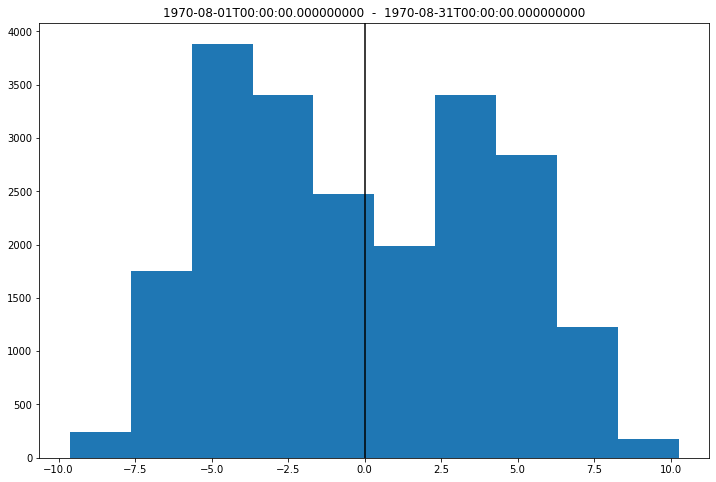

In [91]:
# Flatten U 
Uflat =  Usfc_choice.reshape(len(lat_Afr)*len(lon_Afr)*len(U_choice.time))

fig, ax1 = plt.subplots(1,1, figsize=(12, 8))
ax1.hist(Uflat)
ax1.axvline(0, color='k')
ax1.set_title( str(U_choice.time.values[0])+'  -  '+str(U_choice.time.values[-1]) )

print('Mean U during this month: ', np.nanmean(Usfc_choice))

plt.show


## What does map look like if we average a month together?

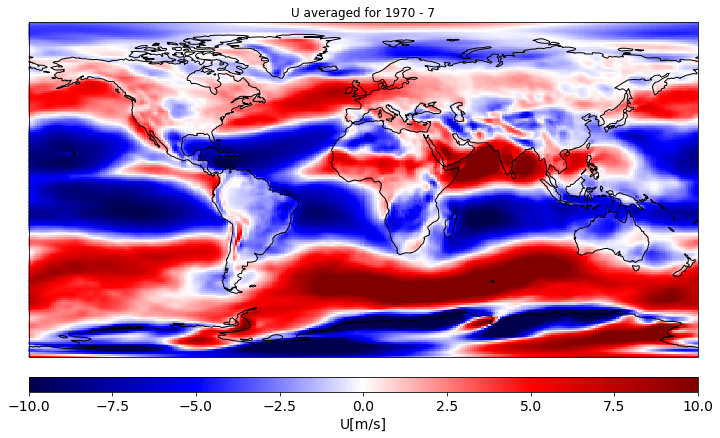

In [97]:
## ---- Choose times ---- ## 
yrSel  = 1970 
monSel = 7

iChoice = np.where((dates.month==monSel) & (dates.year==yrSel))[0]

U_choice    = U_sel.isel(time=iChoice)
Usfc_choice = U_choice.values[:,0,:,:]
Usfc_avg    = np.nanmean(Usfc_choice, axis=0)


## ---- Now plot map ---- ## 
# Set up figure 
fig, ax1 = plt.subplots(1,1, figsize=(12, 8), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})
# Put axs handles in array, axs 

# Make cyclic 
sfcU_day_cyclic, lon_cyclic    = cartopy.util.add_cyclic_point(Usfc_avg, lon)

# Midwest US 
#ax1.set_extent([220,300,20,60])
contour_plot = ax1.pcolormesh(lon_cyclic,lat,sfcU_day_cyclic,
                                 vmin = -10,
                                 vmax = 10,
                                 cmap = 'seismic')
ax1.coastlines()        # Add continent lines 

# Add colorbar 
ax_position = ax1.get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.06, ax_position.width, 0.025])
cbar        = plt.colorbar(contour_plot, orientation='horizontal', cax=cbar_ax)
cbar.set_label('U[m/s]',fontsize=14)
cbar.ax.tick_params(labelsize=14)

# Set title
ax1.set_title('U averaged for '+str(yrSel)+' - '+str(monSel))

plt.show()



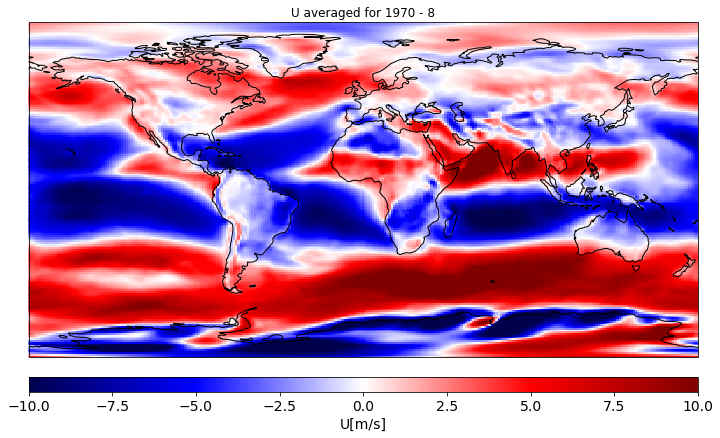

In [98]:
## ---- Choose times ---- ## 
yrSel  = 1970 
monSel = 8

iChoice = np.where((dates.month==monSel) & (dates.year==yrSel))[0]

U_choice    = U_sel.isel(time=iChoice)
Usfc_choice = U_choice.values[:,0,:,:]
Usfc_avg    = np.nanmean(Usfc_choice, axis=0)


## ---- Now plot map ---- ## 
# Set up figure 
fig, ax1 = plt.subplots(1,1, figsize=(12, 8), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})
# Put axs handles in array, axs 

# Make cyclic 
sfcU_day_cyclic, lon_cyclic    = cartopy.util.add_cyclic_point(Usfc_avg, lon)

# Midwest US 
#ax1.set_extent([220,300,20,60])
contour_plot = ax1.pcolormesh(lon_cyclic,lat,sfcU_day_cyclic,
                                 vmin = -10,
                                 vmax = 10,
                                 cmap = 'seismic')
ax1.coastlines()        # Add continent lines 

# Add colorbar 
ax_position = ax1.get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.06, ax_position.width, 0.025])
cbar        = plt.colorbar(contour_plot, orientation='horizontal', cax=cbar_ax)
cbar.set_label('U[m/s]',fontsize=14)
cbar.ax.tick_params(labelsize=14)

# Set title
ax1.set_title('U averaged for '+str(yrSel)+' - '+str(monSel))

plt.show()



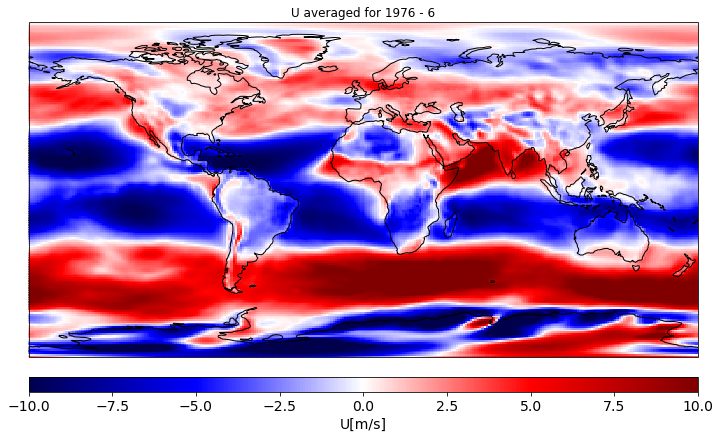

In [101]:
## ---- Choose times ---- ## 
yrSel  = 1976
monSel = 6

iChoice = np.where((dates.month==monSel) & (dates.year==yrSel))[0]

U_choice    = U_sel.isel(time=iChoice)
Usfc_choice = U_choice.values[:,0,:,:]
Usfc_avg    = np.nanmean(Usfc_choice, axis=0)


## ---- Now plot map ---- ## 
# Set up figure 
fig, ax1 = plt.subplots(1,1, figsize=(12, 8), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})
# Put axs handles in array, axs 

# Make cyclic 
sfcU_day_cyclic, lon_cyclic    = cartopy.util.add_cyclic_point(Usfc_avg, lon)

# Midwest US 
#ax1.set_extent([220,300,20,60])
contour_plot = ax1.pcolormesh(lon_cyclic,lat,sfcU_day_cyclic,
                                 vmin = -10,
                                 vmax = 10,
                                 cmap = 'seismic')
ax1.coastlines()        # Add continent lines 

# Add colorbar 
ax_position = ax1.get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.06, ax_position.width, 0.025])
cbar        = plt.colorbar(contour_plot, orientation='horizontal', cax=cbar_ax)
cbar.set_label('U[m/s]',fontsize=14)
cbar.ax.tick_params(labelsize=14)

# Set title
ax1.set_title('U averaged for '+str(yrSel)+' - '+str(monSel))

plt.show()
